## Energy minimization for a 2.5D sheet in 3D

In [1]:
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from scipy import optimize

from tyssue import Sheet

from tyssue import SheetGeometry as geom
from tyssue.dynamics.sheet_vertex_model import SheetModel as model 
from tyssue.solvers.quasistatic import QSSolver
from tyssue import config
from tyssue.solvers.isotropic_solver import bruteforce_isotropic_relax

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.io import hdf5


In [2]:
h5store = 'data/small_hexagonal.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
sheet.sanitize(trim_borders=True, order_edges=True)

geom.update_all(sheet)
sheet.vert_df.describe().head(3)


,y,is_active,z,x,rho,old_idx,basal_shift,height,radial_tension
count,8.000000e+01,80.000000,8.000000e+01,8.000000e+01,8.000000e+01,80.000000,8.000000e+01,8.000000e+01,80.0
mean,1.110223e-15,0.800000,8.881784e-17,-2.620126e-15,8.071634e+00,103.425000,2.216705e+00,5.854929e+00,0.0
std,5.743517e+00,0.402524,8.027290e+00,5.743517e+00,4.968335e-15,27.759261,4.468911e-16,5.000389e-15,0.0


In [3]:
sheet.face_df.describe().head(3)

,area,z,y,is_alive,x,perimeter,old_idx,num_sides,vol,prefered_area,prefered_vol,contractility,vol_elasticity,prefered_height,basal_shift,basal_height,height,rho
count,40.000000,4.000000e+01,4.000000e+01,40.0,4.000000e+01,40.000000,40.000000,40.000000,40.000000,40.0,40.0,40.000000,40.0,40.0,40.000000,40.000000,4.000000e+01,4.000000e+01
mean,31.948614,-1.850372e-18,1.132427e-15,1.0,-2.642331e-15,21.447238,27.500000,5.600000,187.056872,12.0,288.0,76.076404,1.0,24.0,2.500252,-3.246161,5.854929e+00,8.071634e+00
std,2.890942,7.446702e+00,5.463498e+00,0.0,5.463498e+00,0.549335,16.306362,0.496139,16.926260,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,2.520187e-15,2.544151e-15


In [4]:
sheet.edge_df.describe().head(3)

,dz,length,dx,dy,srce,trgt,face,old_jv0,old_jv1,old_cell,...,sz,tx,ty,tz,fx,fy,fz,rx,ry,rz
count,2.240000e+02,224.000000,2.240000e+02,2.240000e+02,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,...,224.000000,2.240000e+02,2.240000e+02,224.000000,2.240000e+02,2.240000e+02,224.000000,2.240000e+02,2.240000e+02,2.240000e+02
mean,3.965082e-18,3.829864,-1.982541e-17,-7.930164e-18,39.500000,39.500000,19.500000,99.348214,106.031250,27.500000,...,0.000000,-2.727977e-15,1.268826e-15,0.000000,-2.569373e-15,1.015061e-15,0.000000,-1.982541e-17,3.965082e-18,2.973812e-17
std,2.593865e+00,0.652700,2.053231e+00,2.053231e+00,23.111351,23.111351,11.563046,27.073959,27.627631,16.132856,...,7.530508,5.720290e+00,5.720290e+00,7.530508,5.409339e+00,5.409339e+00,7.117109,1.860313e+00,1.860313e+00,2.460756e+00


## Non dimensionalisation and isotropic model


For our 2D1/2 model, for a tissue energy is expressed as:
$$
E = N_f\frac{K}{2}(V - V_0)^2 + N_f \frac{\Gamma}{2}L^2 + 3N_f\Lambda \ell 
$$
In the case of a regular, infinite hexagonal lattice, There 6 edges per cell, each shared bteween 2 cells, hence $Ne = 3N_f$

We can write this equation as a dimension-less one by dividing it by $N_f K V_0^2$. We define the dimension-less values: $\bar\Gamma = \Gamma/K V_0^{4/3}$ and $\bar\Lambda = \Lambda/K V_0^{5/3}$

$$
\bar{E} = \frac{\left(V/V_0 - 1\right)^2}{2} + \bar\Gamma \frac{V_0^{-2/3}}{2}L^2 + 3\bar\Lambda V_0^{-1/3} \ell
$$

We define the scaling factor $\delta$ such that $V/V_0 = \delta^3$. On a regular hexagonal grid, the perimeter $L=6\ell$ and the area is A=$3\sqrt{3}/2\,\ell^2$. The volume is $V = Ah$. As the (pseudo-)height is arbitrary, we can chose its prefered value. We set $h_0 = V_0^{1/3}$.

We thus have $A_0 = V_0^{2/3}$, $A = \delta^2 V_0^{2/3}$ and 
$\ell = \delta (\frac{2}{3\sqrt{3}})^{1/2} V_0^{1/3}$. We define the constant $\mu = 2^{3/2}3^{1/4}$ to simplify further the equation:

$$
\begin{eqnarray}
\bar{E} &=& \frac{(\delta^3 - 1)^2}{2} + \frac{12}{\sqrt{3}}\bar\Gamma\delta^2 + \frac{6}{\sqrt{3}}\bar\Lambda \delta \\
\bar{E} &=& \frac{(\delta^3 - 1)^2}{2} + \frac{\mu^2}{2}\bar\Gamma\delta^2 + \frac{\mu}{2}\bar\Lambda \delta \\
\end{eqnarray}
$$


The root of this polynomial corresponds to the lowest energy possible for this set of paramters.






### This analytic model is implemented bellow

It is now a bit too specific to warrant a module in tyssue, and was thus removed


In [5]:
"""
Isotropic energy model from Farhadifar et al. 2007 article
"""
import numpy as np

mu = 2 ** 1.5 * 3 ** 0.25


def elasticity(delta):
    return (delta ** 3 - 1) ** 2 / 2.0


def contractility(delta, gamma):
    return gamma * mu ** 2 * delta ** 2 / 2.0


def tension(delta, lbda):
    return lbda * mu * delta / 2.0


def isotropic_energies(sheet, model, geom, deltas, nondim_specs):

    # bck_face_shift = sheet.face_df['basal_shift']
    # bck_vert_shift = sheet.vert_df['basal_shift']
    # ## Faces only area and height

    V_0 = sheet.specs["face"]["prefered_vol"]
    vol_avg = sheet.face_df[sheet.face_df["is_alive"] == 1].vol.mean()
    rho_avg = sheet.vert_df.rho.mean()

    # ## Set height and volume to height0 and V0
    delta_0 = (V_0 / vol_avg) ** (1 / 3)
    geom.scale(sheet, delta_0, sheet.coords)

    h_0 = V_0 ** (1 / 3)

    sheet.face_df["basal_shift"] = rho_avg * delta_0 - h_0
    sheet.vert_df["basal_shift"] = rho_avg * delta_0 - h_0
    geom.update_all(sheet)

    energies = np.zeros((deltas.size, 3))
    for n, delta in enumerate(deltas):
        geom.scale(sheet, delta, sheet.coords + ["basal_shift"])
        geom.update_all(sheet)
        Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
        energies[n, :] = [Et.sum(), Ec.sum(), Ev.sum()]
        geom.scale(sheet, 1 / delta, sheet.coords + ["basal_shift"])
        geom.update_all(sheet)
    energies /= sheet.face_df["is_alive"].sum()
    isotropic_relax(sheet, nondim_specs)

    return energies


def isotropic_relax(sheet, nondim_specs, geom=geom):
    """Deforms the sheet so that the faces pseudo-volume is at their
    isotropic optimum (on average)
    The specified model specs is assumed to be non-dimentional
    """

    vol0 = sheet.face_df["prefered_vol"].mean()
    h_0 = vol0 ** (1 / 3)
    live_faces = sheet.face_df[sheet.face_df.is_alive == 1]
    vol_avg = live_faces.vol.mean()
    rho_avg = sheet.vert_df.rho.mean()

    # ## Set height and volume to height0 and vol0
    delta = (vol0 / vol_avg) ** (1 / 3)
    geom.scale(sheet, delta, coords=sheet.coords)
    sheet.face_df["basal_shift"] = rho_avg * delta - h_0
    sheet.vert_df["basal_shift"] = rho_avg * delta - h_0
    geom.update_all(sheet)

    # ## Optimal value for delta
    delta_o = find_grad_roots(nondim_specs)
    if not np.isfinite(delta_o):
        raise ValueError("invalid parameters values")
    sheet.delta_o = delta_o
    # ## Scaling
    geom.scale(sheet, delta_o, coords=sheet.coords + ["basal_shift"])
    geom.update_all(sheet)


def isotropic_energy(delta, mod_specs):
    """
    Computes the theoritical energy per face for the given
    parameters.
    """
    lbda = mod_specs["edge"]["line_tension"]
    gamma = mod_specs["face"]["contractility"]
    elasticity_ = (delta ** 3 - 1) ** 2 / 2.0
    contractility_ = gamma * mu ** 2 * delta ** 2 / 2.0
    tension_ = lbda * mu * delta / 2.0
    energy = elasticity_ + contractility_ + tension_
    return energy


def isotropic_grad_poly(mod_specs):
    lbda = mod_specs["edge"]["line_tension"]
    gamma = mod_specs["face"]["contractility"]

    grad_poly = [3, 0, 0, -3, mu ** 2 * gamma, mu * lbda / 2.0]
    return grad_poly


def isotropic_grad(mod_specs, delta):
    grad_poly = isotropic_grad_poly(mod_specs)
    return np.polyval(grad_poly, delta)


def find_grad_roots(mod_specs):
    poly = isotropic_grad_poly(mod_specs)
    roots = np.roots(poly)
    good_roots = np.real([r for r in roots if np.abs(r) == r])
    np.sort(good_roots)
    if len(good_roots) == 1:
        return good_roots
    elif len(good_roots) > 1:
        return good_roots[0]
    else:
        return np.nan

In [6]:
nondim_specs = config.dynamics.quasistatic_sheet_spec()
dim_model_specs = model.dimensionalize(nondim_specs)

sheet.update_specs(dim_model_specs, reset=True)
sheet.edge_df.is_active = (sheet.upcast_face(sheet.face_df.is_alive)
                           & sheet.upcast_srce(sheet.vert_df.is_active))
res = bruteforce_isotropic_relax(sheet, geom, model)

Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_height of the face dataset with new specs
Reseting column prefered_area of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs
Reseting column radial_tension of the vert dataset with new specs
Reseting column is_active of the vert dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column uz of the edge dataset with new specs
Reseting column line_tension of the edge dataset with new specs
Reseting column is_active of the edge dataset with new specs


In [7]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 18.662021831602555


In [8]:
def plot_analytical_to_numeric_comp(sheet, model, geom, nondim_specs):

    fig, ax = plt.subplots(figsize=(8, 8))

    deltas = np.linspace(0.1, 1.8, 50)

    lbda = nondim_specs["edge"]["line_tension"]
    gamma = nondim_specs["face"]["contractility"]

    ax.plot(
        deltas,
        isotropic_energy(deltas, nondim_specs),
        "k-",
        label="Analytical total",
    )
    try:
        ax.plot(sheet.delta_o, isotropic_energy(sheet.delta_o, nondim_specs), "ro")
    except:
        pass
    ax.plot(deltas, elasticity(deltas), "b-", label="Analytical volume elasticity")
    ax.plot(
        deltas,
        contractility(deltas, gamma),
        color="orange",
        ls="-",
        label="Analytical contractility",
    )
    ax.plot(deltas, tension(deltas, lbda), "g-", label="Analytical line tension")

    ax.set_xlabel(r"Isotropic scaling $\delta$")
    ax.set_ylabel(r"Isotropic energie $\bar E$")

    energies = isotropic_energies(sheet, model, geom, deltas, nondim_specs)
    # energies = energies / norm
    ax.plot(
        deltas,
        energies[:, 2],
        "bo:",
        lw=2,
        alpha=0.8,
        label="Computed volume elasticity",
    )
    ax.plot(
        deltas, energies[:, 0], "go:", lw=2, alpha=0.8, label="Computed line tension"
    )
    ax.plot(
        deltas,
        energies[:, 1],
        ls=":",
        marker="o",
        color="orange",
        label="Computed contractility",
    )
    ax.plot(
        deltas, energies.sum(axis=1), "ko:", lw=2, alpha=0.8, label="Computed total"
    )

    ax.legend(loc="upper left", fontsize=10)
    ax.set_ylim(0, 1.2)
    print(sheet.delta_o, deltas[energies.sum(axis=1).argmin()])

    return fig, ax


0.8865926873873902 0.8979591836734694


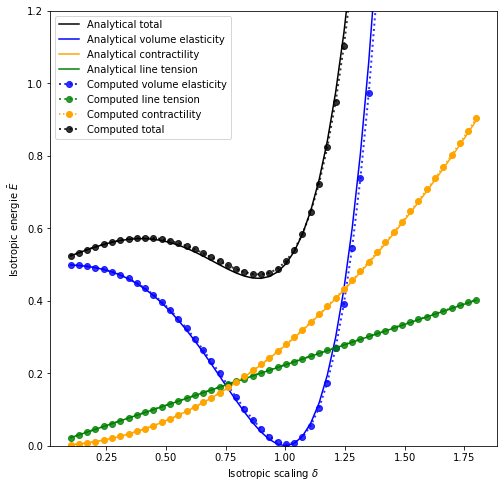

In [9]:
fig, ax = plot_analytical_to_numeric_comp(sheet, model, geom, nondim_specs)


In [10]:
model.labels

['Line tension', 'Contractility', 'Volume elasticity']

In [11]:
gradients = model.compute_gradient(sheet, components=True)
gradients = {label: (srce, trgt) for label, (srce, trgt)
             in zip(model.labels, gradients)}
gradients['Line tension'][0].head()

,gx,gy,gz
edge,,,
0,-0.000000,-0.000000,-753.596252
1,-0.000000,-0.000000,753.596252
2,127.116863,639.059628,378.617758
3,-127.116863,639.059628,-378.617758
4,127.116863,-639.059628,378.617758


In [12]:
grad_i = model.compute_gradient(sheet, components=False)
grad_i.head()

,gx,gy,gz
srce,,,
0,-0.006679,-2.766522e-03,-0.007526
1,-0.006679,2.766522e-03,-0.007526
2,-0.016345,6.770145e-03,-0.009976
3,-0.011138,-7.744148e-17,-0.008208
4,-0.016345,-6.770145e-03,-0.009976


In [13]:
geom.scale(sheet, 1.2, sheet.coords)
geom.update_all(sheet)

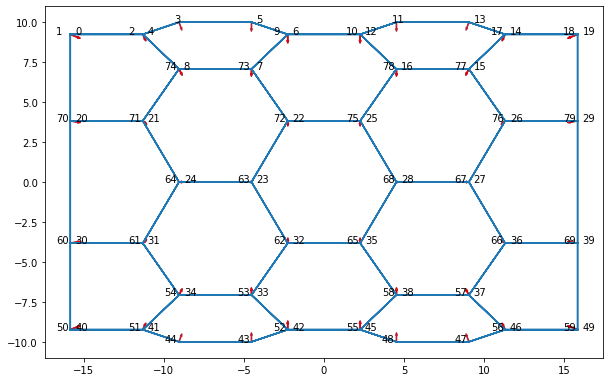

In [14]:

scale = 5

fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})

solver = QSSolver()    
sheet.topo_changed = False


def draw_approx_force(ax=None):
    fig, ax = draw.plot_forces(sheet, geom, model,
                              ['z', 'x'], scaling=scale, ax=ax,
                              approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [15]:

grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.Nv


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))


Error on the gradient (non-dim, per vertex): 1.689e-05


In [16]:
settings = {
        'options': {'disp':False,
                    'ftol':1e-5,
                    'gtol':1e-5},
        }


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


In [17]:
res['message']

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [18]:
res['fun']/sheet.face_df.is_alive.sum()

0.42904245873706837

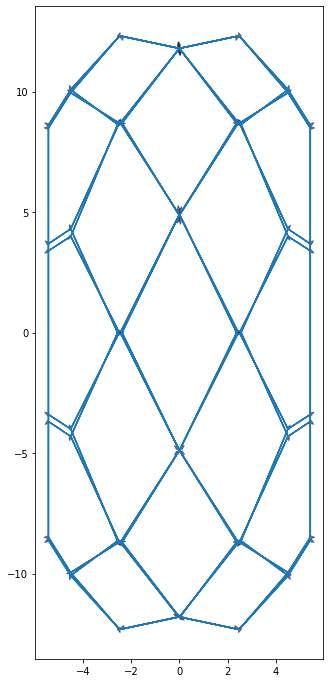

In [19]:
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'y'], 10)
fig.set_size_inches(10, 12)
